In [1]:
%matplotlib widget

<Axes3D: >

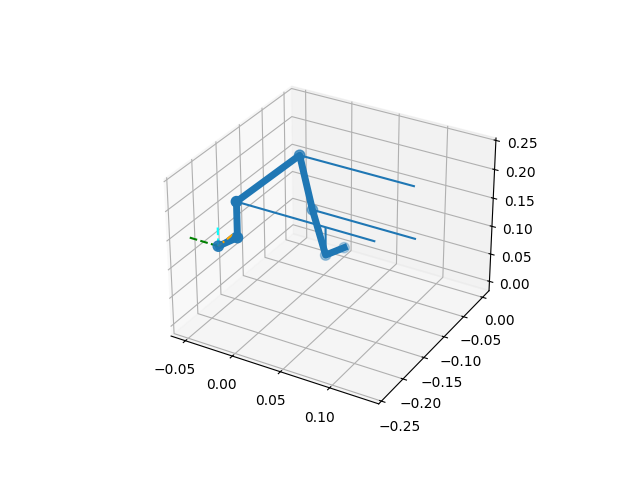

In [2]:
from __future__ import annotations

from threading import Thread
from typing import TYPE_CHECKING

import numpy as np
from teleop import Teleop
import ikpy
import ikpy.chain

import matplotlib.pyplot as plt


from lerobot.common.robot_devices.motors.feetech import TorqueMode


import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D
ax = matplotlib.pyplot.figure().add_subplot(111, projection='3d')


# This is relative to the zero position from examples/10_use_so100.md assuming you calibrated
# everything correctly (which I struggled with, and still don't have perfect)
INITIAL_ANGLES = np.array(
    [
        # orientation of base link, to make ikpy happy
        0,
        0,
        # FIXME: why does the follower robot inch down by ~0.5cm every time I restart the program?
        90 + 30,
        90,
        90,
        0,
        0,
    ]
)




def degrees_to_radians(degrees: np.ndarray) -> np.ndarray:
    return degrees * np.pi / 180


def radians_to_degrees(radians: np.ndarray) -> np.ndarray:
    return radians * 180 / np.pi


# a hacky object that doesn't have __slots__ defined, so I can copy paste code from my teleop class
def self():
        pass

if 1:
        self.ik_chain = my_chain = ikpy.chain.Chain.from_urdf_file(
            "../SO-ARM100/URDF/SO_5DOF_ARM100_8j_URDF.SLDASM/urdf/SO_5DOF_ARM100_8j_URDF.SLDASM.urdf",
            base_elements=["Base"],
            active_links_mask=[False, True, True, True, True, True, True],
        )
        my_chain.plot(degrees_to_radians(INITIAL_ANGLES * 0), ax, )

        # add "Base" to the start of the angles
        self.initial_position = self.ik_chain.forward_kinematics(
            degrees_to_radians(INITIAL_ANGLES),
        )  # type: ignore - list case only happens if we say full_kinematics=True
        
        # self.ik_chain.plot(self.initial_position, ax, show=True)

plt.ion()

ax

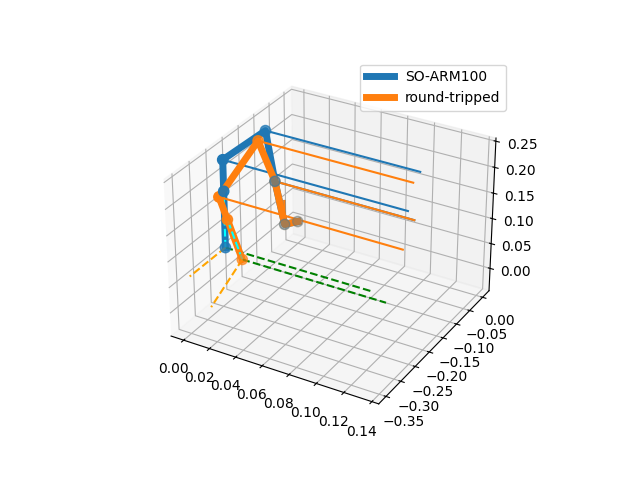

In [18]:
ax = matplotlib.pyplot.figure().add_subplot(111, projection='3d')

GRIPPER_OFFSET = np.array(
    [
        # orientation of base link, to make ikpy happy
        0,
        0,
        0,
        0,
        0,
        0,
        # gripper
        20,
    ]
)


hacked_chain = ikpy.chain.Chain.from_urdf_file(
            "../SO-ARM100/URDF/SO_5DOF_ARM100_8j_URDF.SLDASM/urdf/SO_5DOF_ARM100_8j_URDF.SLDASM.urdf",
            base_elements=["Base"],
            active_links_mask=[False, True, True, True, True, True, False, False],
            name="SO-ARM100",
            # Distance from wrist roll to tip of static jaw, measured with a tape measure.
            last_link_vector=np.array([ 0, -0.11, 0.    ])
        )
# We don't want the gripper to be part of the chain, so we remove it
hacked_chain.links.remove(hacked_chain.links[-2])


my_chain = ikpy.chain.Chain.from_urdf_file(
            "../SO-ARM100/URDF/SO_5DOF_ARM100_8j_URDF.SLDASM/urdf/SO_5DOF_ARM100_8j_URDF.SLDASM.urdf",
            base_elements=["Base"],
            active_links_mask=[False, True, True, True, True, True, False, False],
            name="round-tripped",
            # Distance from wrist roll to tip of static jaw, measured with a tape measure.
            last_link_vector=np.array([ 0, -0.11, 0.    ])
        )
# We don't want the gripper to be part of the chain, so we remove it
my_chain.links.remove(my_chain.links[-2])


hacked_chain.plot(degrees_to_radians(GRIPPER_OFFSET), ax)
my_chain.plot([ 0.00000000e+00,-2.61878754e-15, 2.23136134e-01, 1.91722355e-01 ,-1.38593345e-02, 0.00000000e+00, 0.00000000e+00], ax)

plt.legend()
plt.show()

From the above plot, you can see that the last joint in the chain is on the knuckle of the gripper,
and changing its angle causes the gripper to rotate (thin dotted lines)

What we really want is to have the last point be the tip of the end effector, and ignore the gripper
motor completely. This might take some manual fucking about with the URDF, or with the chain once
it's been constructed.


In [6]:

my_chain.links[-1
            ].__dict__


{'bounds': (-inf, inf),
 'name': 'Jaw',
 'length': 0.03167648970451114,
 'axis_length': 0.03167648970451114,
 'is_final': False,
 'has_rotation': True,
 'has_translation': False,
 'joint_type': 'revolute',
 'use_symbolic_matrix': True,
 'origin_translation': array([-0.0202, -0.0244,  0.    ]),
 'origin_orientation': array([3.1416, 0.    , 3.1416]),
 'rotation': array([0., 0., 1.]),
 'translation': None,
 'symbolic_transformation_matrix': <function _lambdifygenerated(theta, mu)>}

In [ ]:
import pytorch_kinematics as pk


In [23]:
chain = pk.build_chain_from_urdf(open("../SO-ARM100/URDF/SO_5DOF_ARM100_8j_URDF.SLDASM/urdf/SO_5DOF_ARM100_8j_URDF.SLDASM.urdf", mode='rb').read())

In [ ]:
chain.print_tree()


Base
└── Rotation_Pitch
    └── Upper_Arm
        └── Lower_Arm
            └── Wrist_Pitch_Roll
                └── Fixed_Jaw
                    └── Moving Jaw



'Base\n└── Rotation_Pitch\n    └── Upper_Arm\n        └── Lower_Arm\n            └── Wrist_Pitch_Roll\n                └── Fixed_Jaw\n                    └── Moving Jaw\n'

In [26]:
serial_chain = pk.SerialChain(chain, "Fixed_Jaw")


In [27]:
serial_chain.print_tree()

Base
└── Rotation_Pitch
    └── Upper_Arm
        └── Lower_Arm
            └── Wrist_Pitch_Roll
                └── Fixed_Jaw



'Base\n└── Rotation_Pitch\n    └── Upper_Arm\n        └── Lower_Arm\n            └── Wrist_Pitch_Roll\n                └── Fixed_Jaw\n'

In [29]:
serial_chain.forward_kinematics([0,0,0,0,0,])

Transform3d(rot=tensor([[0.7071, 0.7071, 0.0000, 0.0000]]), pos=tensor([[ 0.0000, -0.2387,  0.1767]]))

In [30]:
serial_chain.forward_kinematics([0,0.1,0,0,0,])


Transform3d(rot=tensor([[0.6709, 0.7416, 0.0000, 0.0000]]), pos=tensor([[ 0.0000, -0.2436,  0.1601]]))

In [91]:
import time
import rerun as rr
from pytorch_kinematics import Transform3d
import torch
from uuid import uuid4


rr.init("notebook", recording_id=uuid4())
rr.connect()


def to_rr(x):
    if isinstance(x, Transform3d):
        return rr.Arrows3D(
            origins=x.transform_points(torch.tensor([[0.,0,0]]))[0],
            vectors=x.transform_normals(torch.tensor([[0,0,0.1]]))[0],
            )
    raise NotImplementedError


for r in range(0, 1):
    time.sleep(0.1)
    links : dict[str, Transform3d] = serial_chain.forward_kinematics([0,0,r/10,0,0,], end_only=False)
    for i, (name, pos) in enumerate(links.items()):
        rr.log(f"forward/{i}-{name}", to_rr(pos))
    

    pos = links["Fixed_Jaw"]

    

    lim = torch.tensor(serial_chain.get_joint_limits())/10
    print("lim", lim)
    ik = pk.PseudoInverseIK(serial_chain, max_iterations=300, num_retries=100,
                        joint_limits=lim.T,
                        early_stopping_any_converged=True,
                        early_stopping_no_improvement="all",
                        debug=False,
                        lr=0.02)
    sol = ik.solve(pos)
    print(sol.converged)
    print(sol.solutions)
    for solution in sol.solutions[0]:
        print(solution)
        time.sleep(0.1)

        for i, (name, pos) in enumerate(serial_chain.forward_kinematics(solution, end_only=False).items()):
            rr.log(f"inverse/{i}-{name}-ik", to_rr(pos))
        


# rr.log("forward", to_rr(serial_chain.forward_kinematics([0,0,0,0,0,])))
# rr.log("forward_plus", to_rr(serial_chain.forward_kinematics([0,0.1,0,0,0,])))

lim tensor([[-0.3142, -0.3142, -0.3142, -0.3142, -0.3142],
        [ 0.3142,  0.3142,  0.3142,  0.3142,  0.3142]])
tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False]])
tensor([[[ 1.1314e-01,  6.8164e-02,  2.8540e-01,  2.0050e-01, -2.1642e-01],
         [-2.1207